# PyTorch Basics

I'll assume that everyone is familiar with python. Training neural nets in bare python is somewhat painful, but fortunately there are several well-established libraries which can help. I like pytorch, which is built upon an earlier library called torch. There are many others, including TensorFlow and Jax.

In [1]:
# We start by importing the libraries we'll use today
import numpy as np
import torch
import torchvision

In [2]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.33019079 0.79115599 0.53016433]
 [0.19352589 0.52861492 0.95683112]]
tensor([[0.3302, 0.7912, 0.5302],
        [0.1935, 0.5286, 0.9568]], dtype=torch.float64)


In [3]:
print(b + 10.0)
print()
print(torch.sin(b))
print()
print(b.sum())
print()
print(b.mean())
print()
print(b.shape)

tensor([[10.3302, 10.7912, 10.5302],
        [10.1935, 10.5286, 10.9568]], dtype=torch.float64)

tensor([[0.3242, 0.7112, 0.5057],
        [0.1923, 0.5043, 0.8174]], dtype=torch.float64)

tensor(3.3305, dtype=torch.float64)

tensor(0.5551, dtype=torch.float64)

torch.Size([2, 3])


Torch believes everything is a *tensor.*

The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that training neural nets basically consits of *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about torch variables is that they (natively) can be differentiated. Again, we'll see why this is important when we learn about backpropagation.

Suppose we want $dy/da$ in the following expression:
- $y = a + b$

In [4]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = a + b
print("a:", a)
print("b:", b)
print("y:", y)

a: tensor([[0.3312]], requires_grad=True)
b: tensor([[0.0790]])
y: tensor([[0.4102]], grad_fn=<AddBackward0>)


Here, $y$ is a function of the input $a$ so we can use PyTorch to compute $dy/da$

In [5]:
y.backward()
print("dy/da:", a.grad)

dy/da: tensor([[1.]])


Let's try this again with a more complex function:
- $y = a^2 \cdot b$



In [6]:
a = torch.rand(1,1, requires_grad=True)
b = torch.rand(1,1)
y = (a**2)*b
print("a:", a)
print("b:", b)
print("y:", y)
y.backward()
print("dy/da:", a.grad)
print("dy/da:", 2 * a * b)

a: tensor([[0.0382]], requires_grad=True)
b: tensor([[0.9591]])
y: tensor([[0.0014]], grad_fn=<MulBackward0>)
dy/da: tensor([[0.0732]])
dy/da: tensor([[0.0732]], grad_fn=<MulBackward0>)


Torch has calculated $dy/da$ using backpropagation which is in agreement with our answer calculated using standard differentiation rules.

Here is an example with matrices and vectors:

In [7]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1, requires_grad = True)

y = torch.matmul(A, x) + b
z = y.sum()

Here, $z$ is a function of the input $x$. Let us now compute the derivative of $z$ with respect to $x$ using backpropagation.

In [8]:
z.backward()
print(x)
print(x.grad)

tensor([[0.7036],
        [0.5930]], requires_grad=True)
tensor([[1.1756],
        [0.7826]])


## Training simple models

Let's jump in with our first, simple model. We will train a logistic classifier (equivalent to using a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. Torchvision also has several other image datasets which we can directly load as variables.

In [9]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


Let's check that everything has been downloaded.

In [10]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Let's investigate to see what's inside the dataset.

In [11]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object given that its first dimension has a size of 1. So we will use the `squeeze` function to get rid of the first dimension.

In [12]:
print(image.squeeze().shape)

torch.Size([28, 28])


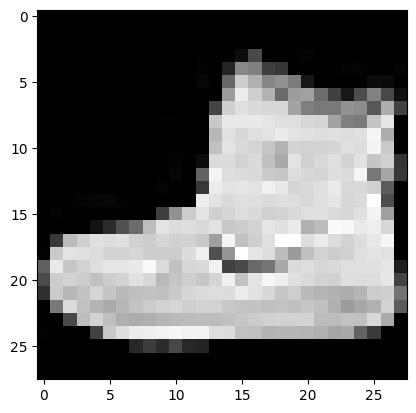

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze(), cmap=plt.cm.gray)

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [14]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's also check the length of the train and test dataloader

In [15]:
print(len(trainDataLoader))
print(len(testDataLoader))

938
157


The length here depends upon the batch size defined above. Multiplying the length of our dataloader by the batch size should give us back the number of samples in each set.

In [16]:
print(len(trainDataLoader) * 64) # batch_size from above
print(len(testDataLoader) * 64)

60032
10048


Now let's use it to look at a few images.

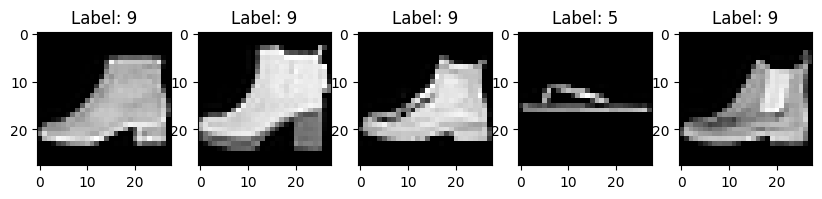

In [17]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

Now let's set up our model.

In [18]:
gpu = "cuda" if torch.cuda.is_available() else "cpu"

class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28, 10)
  
  def forward(self, x):
    x = x.view(-1, 28*28) # change so 784 vector instead of 28x28 matrix
    return self.linear(x)

model = LinearReg().to(gpu)
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method

Now let's train our model!

In [19]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  
  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(gpu)
    labels = labels.to(gpu)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation  
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(gpu)
      labels = labels.to(gpu)
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 0.9601187540142775, Test loss 0.7412131815958934
Epoch 1, Train loss 0.6675267960153409, Test loss 0.6470010595716489
Epoch 2, Train loss 0.6032319129275869, Test loss 0.6036657882723838
Epoch 3, Train loss 0.5681219312554991, Test loss 0.5769736187852872
Epoch 4, Train loss 0.5453312239095346, Test loss 0.5608135051788039
Epoch 5, Train loss 0.5284961068998776, Test loss 0.5464734791950056
Epoch 6, Train loss 0.5161677314274347, Test loss 0.5377659698960128
Epoch 7, Train loss 0.5058915300378158, Test loss 0.5276417339303691
Epoch 8, Train loss 0.49758261766260875, Test loss 0.5204305840525657
Epoch 9, Train loss 0.49031835348049463, Test loss 0.5148852697223615
Epoch 10, Train loss 0.48436400486525694, Test loss 0.509982881462498
Epoch 11, Train loss 0.4789103496271664, Test loss 0.5052185162996791
Epoch 12, Train loss 0.4740513692151255, Test loss 0.5028605480102977
Epoch 13, Train loss 0.46980230416506846, Test loss 0.49784401647604193
Epoch 14, Train loss 0.466

Let's plot our loss by training epoch to see how we did.

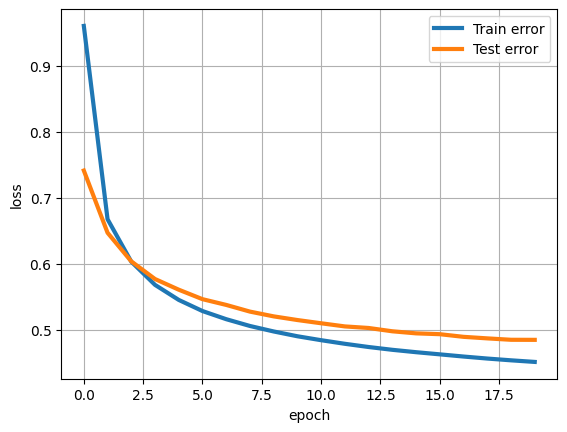

In [20]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Why is test loss larger than training loss?

We definitely see some improvement. Let's look at the images, the predictions our model makes and the true label.

Now for the labels and predicted labels.

In [21]:
predicted_outputs = model(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
0.317776620388031


Text(0.5, 1.0, 'Pred: 1, True: 2')

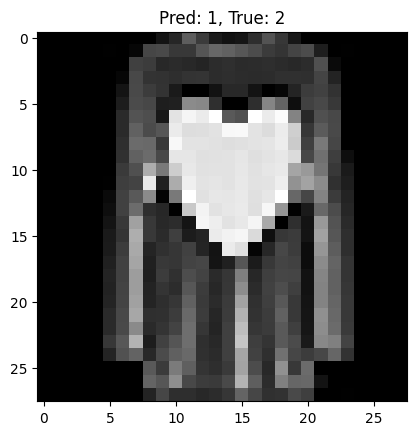

In [22]:
plt.imshow(images[1].squeeze().cpu(), cmap=plt.cm.gray)
plt.title(f'Pred: {predicted_classes[1].item()}, True: {labels[1].item()}')

## Training a more complex model

Start with importing the necessary libraries, dataset, split the data into train and test sets, create a dataloade

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
# Load FashionMNIST datasets
train_data = torchvision.datasets.FashionMNIST(
    './FashionMNIST/', train=True, download=True, transform=transforms.ToTensor()
)
test_data = torchvision.datasets.FashionMNIST(
    './FashionMNIST/', train=False, download=True, transform=transforms.ToTensor()
)

# Create DataLoaders
batch_size = 64
gpu = "cuda" if torch.cuda.is_available() else "cpu"
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Define the model: 

- We will use a simple deep neural network with 3 hidden layers with 784 -> 256 -> 128 -> 64 -> 10 neurons.
- We will use ReLU activation function for each layer.
- We will use SGD optimizer with a learning rate of 0.01
- We will use CrossEntropyLoss as our loss function


In [37]:
class DenseNet(torch.nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.flatten = torch.nn.Flatten()  # Flatten 28x28 images into 784-dim vectors
        self.fc1 = torch.nn.Linear(28*28, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, 10)  # 10 output classes
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = DenseNet().to(gpu)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # SGD optimizer


### Training the model:

We will train the model for 20 epochs and evaluate the model on the test set. All the parameters are the same as the previous model, such as batch size, learning rate, optimizer, loss function, etc. The only difference is the model architecture.

- The model is trained for 20 epochs and the loss is calculated for each epoch.
- The model is evaluated on the test set and the accuracy is calculated.


In [ ]:
# Training loop
num_epochs = 20
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(gpu), labels.to(gpu)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    
    train_loss = running_train_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)
    
    # Evaluate on test set
    model.eval()
    running_test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(gpu), labels.to(gpu)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    test_loss = running_test_loss / len(test_loader.dataset)
    test_loss_history.append(test_loss)
    accuracy = 100 * correct / len(test_loader.dataset)
    test_accuracy_history.append(accuracy)
    
    print(f"Epoch {epoch} Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {accuracy:.2f}%")



Epoch 1/20: Train Loss = 1.8749, Test Loss = 1.0741, Test Accuracy = 58.30%
Epoch 2/20: Train Loss = 0.8227, Test Loss = 0.7516, Test Accuracy = 72.70%
Epoch 3/20: Train Loss = 0.6611, Test Loss = 0.6472, Test Accuracy = 77.30%
Epoch 4/20: Train Loss = 0.5869, Test Loss = 0.5924, Test Accuracy = 79.30%
Epoch 5/20: Train Loss = 0.5434, Test Loss = 0.5716, Test Accuracy = 79.76%
Epoch 6/20: Train Loss = 0.5154, Test Loss = 0.5378, Test Accuracy = 80.87%
Epoch 7/20: Train Loss = 0.4944, Test Loss = 0.5345, Test Accuracy = 81.41%
Epoch 8/20: Train Loss = 0.4762, Test Loss = 0.5048, Test Accuracy = 81.83%
Epoch 9/20: Train Loss = 0.4585, Test Loss = 0.4834, Test Accuracy = 82.62%
Epoch 10/20: Train Loss = 0.4425, Test Loss = 0.4649, Test Accuracy = 83.65%
Epoch 11/20: Train Loss = 0.4304, Test Loss = 0.5478, Test Accuracy = 79.21%
Epoch 12/20: Train Loss = 0.4152, Test Loss = 0.5898, Test Accuracy = 77.75%
Epoch 13/20: Train Loss = 0.4047, Test Loss = 0.4532, Test Accuracy = 83.86%
Epoch 14

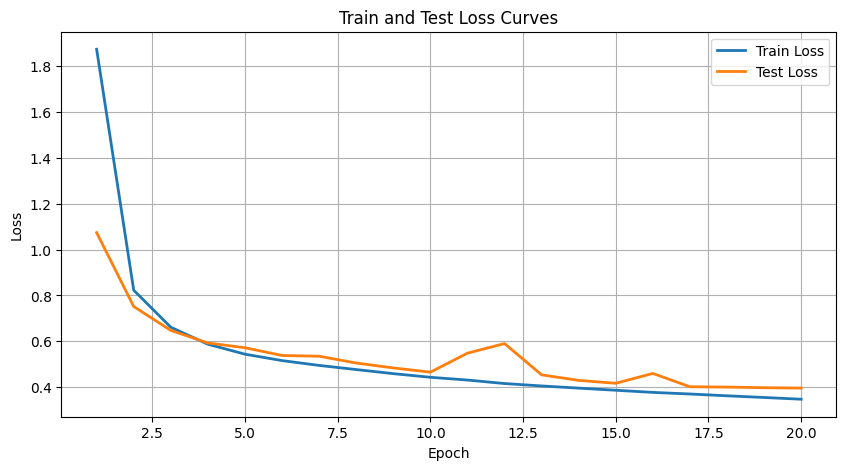

Final Test Accuracy: 85.82%


In [41]:
# Plot loss curves
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs+1), test_loss_history, label='Test Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Report final test accuracy
print(f"Final Test Accuracy: {test_accuracy_history[-1]:.2f}%")

### Model Evaluation:

We see that the model is able to achieve an accuracy of 85% on the test set. This is a significant improvement over the previous model. The model is able to learn the features of the images and make accurate predictions.

We can further test the model by passing a random image from the test set and checking the prediction made by the model and the true label of the image.

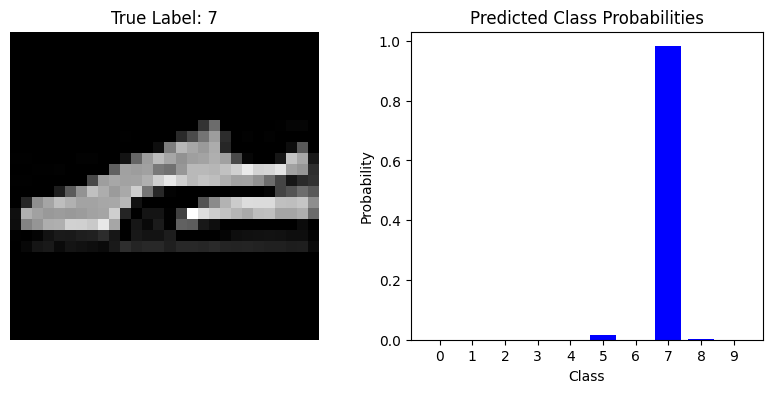

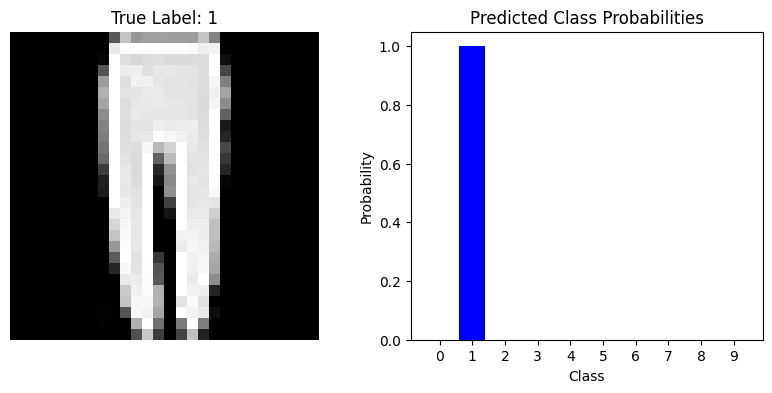

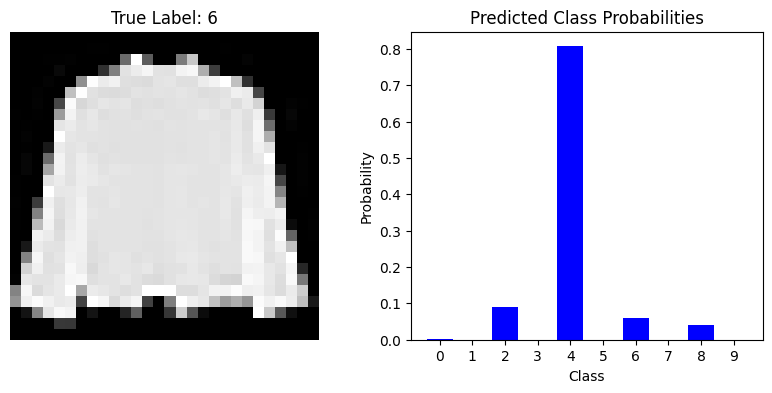

In [42]:
import random
# Visualize predictions for 3 random test images
model.eval()
for _ in range(3):
    idx = random.randint(0, len(test_data) - 1)
    image, true_label = test_data[idx]
    
    # Prepare image for the model: add batch dimension and send to device
    input_img = image.unsqueeze(0).to(gpu)
    output = model(input_img)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(output, dim=1).cpu().detach().numpy()[0]
    
    # Plot the image and a bar chart of predicted class probabilities
    plt.figure(figsize=(10,4))
    
    # Image subplot
    plt.subplot(1,2,1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True Label: {true_label}")
    plt.axis("off")
    
    # Bar chart subplot
    plt.subplot(1,2,2)
    plt.bar(np.arange(10), probabilities, color='blue')
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.title("Predicted Class Probabilities")
    plt.xticks(np.arange(10))
    
    plt.show()

### Conclusion

We can see that changing the model architecture from a simple linear model to a deep neural network with multiple hidden layers has significantly improved the performance of the model. The model is able to learn the features of the images and make accurate predictions. 

Some images, such as the last one we tested, are still not predicted with 100% confidence given the complexity of the shapes and patterns in the image. However, the model is able to make accurate predictions on most of the images in the test set.